---
# Part 2, Figure 4
Surface presence and volumes by oil types

---

This code requires output from code run on Compute Canada's HPC. For the purpose of this publication, this code has been placed in `../scripts/HPC_scripts/HPC_aggregate_mass_balance.py`

Package requirements are included in ../environment.yaml.  Install in the upper-level directory using:
```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]

**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created by Susan Allen with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/`
- a graphics style template in [../graphics_utils](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/publish/graphics_utils) was used.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
import os
import matplotlib.ticker as ticker
import matplotlib

# set colormap so it's white (water) and papayawhip (land)
my_cmap = matplotlib.colormaps['Greens'].copy()
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

In [2]:
# define directory paths
graphics_directory = Path('../')
# Aggregated files path
agg_dir = Path('../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/')
# graphics style
plt.style.use(r"../graphics_utils/style.template")

# Load SalishSeaCast grid 

In [3]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

# Load aggregated results

In [4]:
beach={}
water={}
sfc={}
sfc_presence_diff={}
sfc_presence={}
ma_surface_diff={}
ma_surface={}

eps = 1e-7 # to impose values > 0
cubicmeter_to_ML = 1e-3
smalloils = 113 + 54  # Small spills in 10,000 that didn't meet thresholds but were a part of 10,000 spills

In [5]:
## Load oil types
oil_types = ['akns','bunker','diesel','dilbit','oils']
for oil_type in oil_types:
    print(f'***{oil_type}***')
    
    oil = xr.open_dataset(agg_dir/f'fiftieth_55_{oil_type}.nc')
    
    # geometric mean beached oil
    ma_beach_oil = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0
    )
    beach2d = np.exp(ma_beach_oil)
    
    # geometric mean Deep Oil (depth integrated: $m^3$)
    ma_deep_oil = np.ma.masked_array(
        oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0
    )
    water2d = np.exp(ma_deep_oil)
       
    # Surface Oil Geometric mean thickness ($m^3$)
    ma_surface_oil = np.ma.masked_array(
        oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0
    ) 
    sfc2d = np.exp(ma_surface_oil)
        
    # Surface Oil Presence
    ma_oil_pres = np.ma.masked_array(
        oil.oilpresence, oil.oilpresence == 0
    )
    # Store surface thickness by oil type
    ma_surface[oil_type]=ma_surface_oil    
    # Store surface presence by oil type
    sfc_presence[oil_type]=ma_oil_pres
    
    # create dictionaries used for plotting results
    water[oil_type] = water2d.sum()*cubicmeter_to_ML
    sfc[oil_type] = sfc2d.sum()*cubicmeter_to_ML
    beach[oil_type] = beach2d.sum()*cubicmeter_to_ML

***akns***
***bunker***
***diesel***
***dilbit***
***oils***


# Graphic specifications

In [6]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# Plot surface presence by oil types

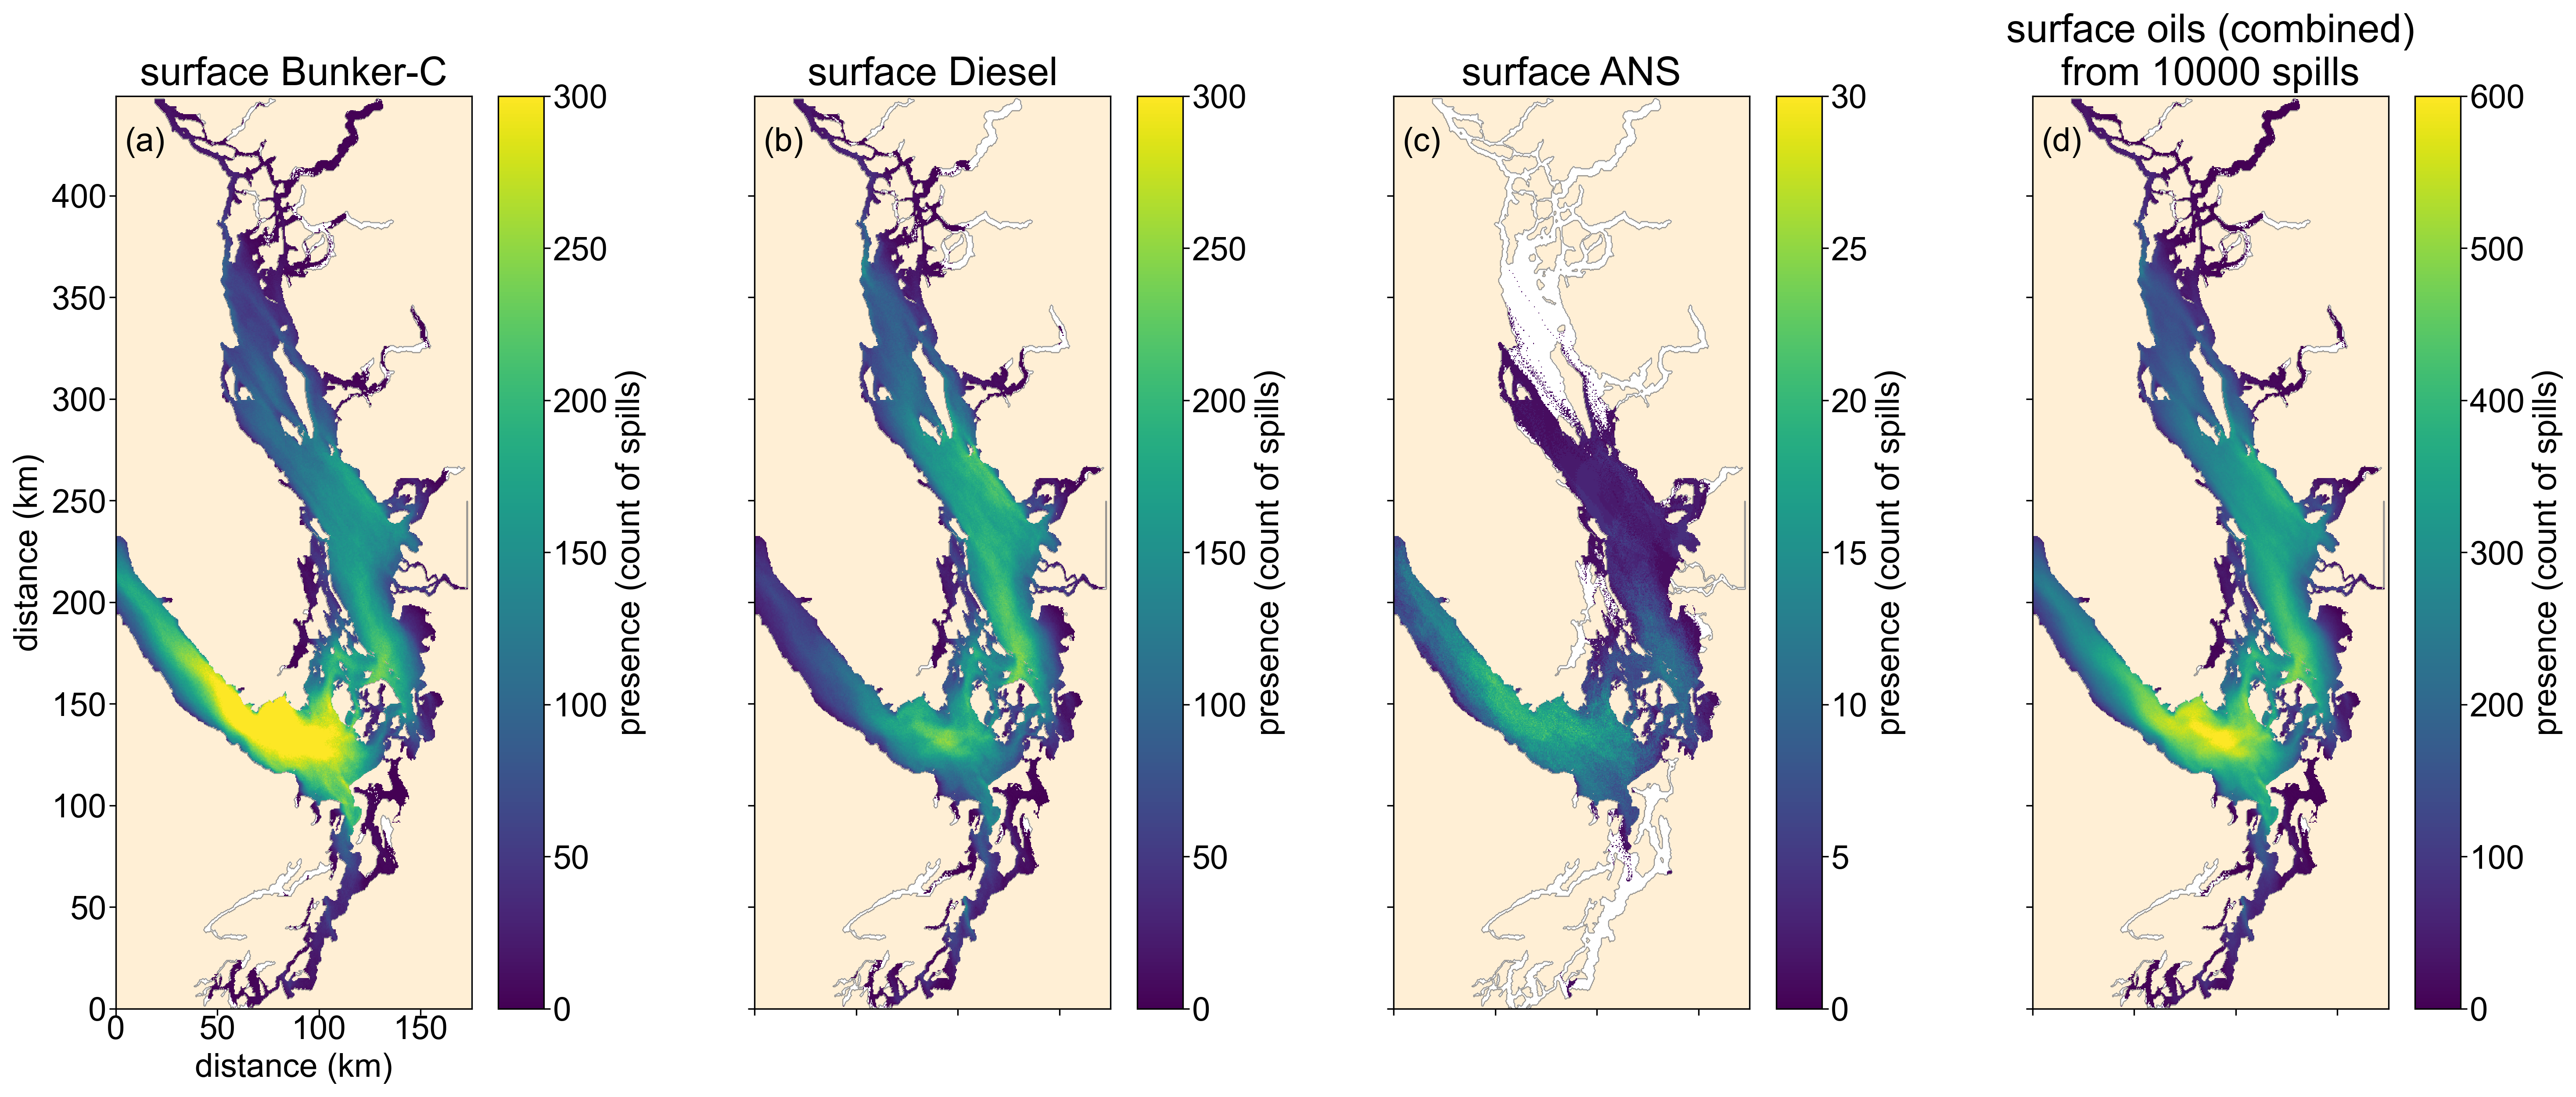

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(24, 9),
    gridspec_kw={'hspace': 0.0})

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=.1, vmax=.8)
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
 
    
C = axs[0].pcolormesh(sfc_presence['bunker'], vmin=0, vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title('surface Bunker-C');  

C = axs[1].pcolormesh(sfc_presence['diesel'],  vmin=0, vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[1]);    
cb.set_label('presence (count of spills)')
axs[1].set_title('surface Diesel');   

C = axs[2].pcolormesh(sfc_presence['akns'],  vmin=0, vmax=30, zorder=2)
cb = fig.colorbar(C, ax=axs[2]);    
cb.set_label('presence (count of spills)')
axs[2].set_title('surface ANS');   

C = axs[3].pcolormesh(sfc_presence['oils'], vmin=0, vmax=600, zorder=2)
cb = fig.colorbar(C, ax=axs[3]);    
cb.set_label('presence (count of spills)')
axs[3].set_title(f'surface oils (combined)\nfrom {oil.nofiles.values+smalloils} spills');  

# add subplot labels
subplot_labels=['(a)','(b)','(c)','(d)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig(graphics_directory/'Figure10_surface_presence.png')